In [6]:
%matplotlib inline

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.stats
from datetime import datetime

import os
from cognite.client import CogniteClient, ClientConfig
from cognite.client.exceptions import *
from cognite.client.utils import ms_to_datetime

In [8]:
#login details
TENANT_ID = "45472a8e-6a12-4531-97d8-1f38f5d553a4"
CLIENT_ID = "d6e5d5fe-faab-4ec6-96a6-acda630388e4"
CDF_CLUSTER = "westeurope-1"
COGNITE_PROJECT = "slb-demo"
SCOPES = [f'https://{CDF_CLUSTER}.cognitedata.com/.default']
TOKEN_URL = f'https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token'


In [9]:
# Login using secret
from cognite.client.credentials import OAuthClientCredentials
from getpass import getpass
def create_cdf_client_sectret(secret):
    creds = OAuthClientCredentials(token_url=TOKEN_URL,
                                   client_id=CLIENT_ID,
                                   client_secret=secret['client-secret'],
                                   scopes=SCOPES)
    cnf = ClientConfig(client_name="cognite",
                       base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
                       project=COGNITE_PROJECT,
                       credentials=creds)
    client = CogniteClient(cnf)
    return client
CLIENT_SECRET = getpass("Enter the Client Secret: ")
client=create_cdf_client_sectret({'client-secret':CLIENT_SECRET})

Enter the Client Secret:  ········································


C:\Users\GunnarStaff\AppData\Local\Temp\ipykernel_16648\3956071245.py:9: UserWarning: You are using version='4.5.3' of the SDK, however version='4.5.4' is available. To suppress this warning, either upgrade or do the following:
>>> from cognite.client.config import global_config
>>> global_config.disable_pypi_version_check = True
  cnf = ClientConfig(client_name="cognite",


# Asset exploration
We will go through different ways if searching for assets and retrieveing them

## Directly retrieve an asset 
Internal or external ID is known so we can directly retrieve the asset

In [12]:
asset=client.assets.retrieve(external_id='WMT:23-1ST STAGE COMPRESSION-PH')
asset

,value
external_id,WMT:23-1ST STAGE COMPRESSION-PH
name,23-1ST STAGE COMPRESSION-PH
parent_id,300360093265086
parent_external_id,230900
description,1ST STAGE COMPRESSION ON PH
data_set_id,6489882897027809
id,7427114983769607
created_time,1665995920096
last_updated_time,1666000501704
root_id,6930604076373423


We can list all assets that match provided (optional) filter criterias 

In [13]:
# List all assets, but filter based on a data set
client.assets.list(limit=5,data_set_ids=[6489882897027809])

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,id,created_time,last_updated_time,root_id
0,23-TE-96115-04,23-TE-96115-04,7274702628750174,WMT:23-DB-9101,VRD - PH 1STSTGGEAR THRUST BRG IN,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '525283', ...",2865808569643,1665995967818,1666608278424,6930604076373423
1,23-KA-9101-EPE,23-KA-9101-EPE,7604246490330115,WMT:23-KA-9101,VRD - PH 1ST STAGE EXPCOMPR POLY EFF,6489882897027809,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",2977600188339,1665995948879,1666608278536,6930604076373423
2,23-FG-96101-02,23-FG-96101-02,6512073296344709,WMT:23-1ST STAGE COMP LUBE OIL SYS-PH,VRD - PH 1STSTG LUBE OIL RET,6489882897027809,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",10028782096003,1665995948879,1666608278637,6930604076373423
3,23-PDT-96143,23-PDT-96143,6747864829217571,WMT:23-1ST STAGE COMP ENCLOSURE-PH,VRD - PH 1STSTG COMPR ENCL AIRFILTER,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '394864', ...",33776788621911,1665995948879,1666608278732,6930604076373423
4,23-GK-9107A-H01,23-GK-9107A-H01,3989290082113233,23-GK-9107A,VRD - 1ST STAGE COMPRESSOR ENCLOSURE COOLING U...,6489882897027809,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",45603138880573,1665995967818,1666608278815,6930604076373423


## Different ways of searching for the assets

Fuzzy search by name

In [14]:
assets = client.assets.search(name="23-PT",limit=5)
assets

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,id,created_time,last_updated_time,root_id
0,23-PT-92501A-11,23-PT-92501A-11,8485853903404594,WMT:23-ESDV-92501A,VRD - PH V-MAP PRESSURE INPUT 1STSTGSUCTCLR GA...,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '495193', ...",1137480696663380,1665995948879,1666608289327,6930604076373423
1,WMT:23-PT-92501B-11,23-PT-92501B-11,2852479709895751,23-ESDV-92501B,VRD - PH V-MAP PRESSURE INPUT 1STSTGSUCTCLR GA...,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '495193', ...",6709337735752245,1665995948879,1666000493100,6930604076373423
2,23-PT-92504,23-PT-92504,4444987486534481,23-HA-9103,VRD - PH 1STSTGSUCTCOOL GAS OUT,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '495056', ...",1827077186228150,1665995931823,1666608296700,6930604076373423
3,23-PT-92512,23-PT-92512,4444987486534481,23-HA-9103,VRD - PH 1STSTGSUCTCOOL GAS IN,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '495056', ...",4050740652066526,1665995931823,1666608319283,6930604076373423
4,23-PT-92521,23-PT-92521,2165956598447685,23-VG-9101,VRD - PH 1STSTGSUCTSCRUBBER,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '495056', ...",1518189807027899,1665995923199,1666608293781,6930604076373423


Fuzzy search by description

In [15]:
assets = client.assets.search(description="Ball Valve",limit=5)
assets

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,labels,id,created_time,last_updated_time,root_id
0,21PI1017,21PI1017,4952987395665623,21,"NPS12 BALL VALVE FB M, CLASS 300, PER DATASHEE...",4137214099874632,"{'Category Code': 'ADM', 'EQUIPMENT/LINE NUMBE...","[{'externalId': 'EQUIPMENT_VALVE_BALL'}, {'ext...",119997796654784,1666606590963,1668246415709,6930604076373423
1,21PI1032,21PI1032,4952987395665623,21,"NPS16 BALL VALVE FB M, CLASS 300, PER DATASHEE...",4137214099874632,"{'Category Code': 'ADM', 'EQUIPMENT/LINE NUMBE...","[{'externalId': 'EQUIPMENT_VALVE_BALL'}, {'ext...",4488343400530291,1666606591559,1668246415890,6930604076373423
2,WMT:23-XV-92748-J01,23-XV-92748-J01,3359780004661677,23-XV-92748,"CONTROL VALVE, JUNCTION BOX",6489882897027809,"{'ELC_STATUS_ID': '1212', 'SOURCE_DB': 'workma...",NaN,7357235119241667,1665995948879,1666000500596,6930604076373423
3,45-V-90352,45-V-90352,4154633518958524,45-PT-92508,VRD - MANUAL VALVE - CBAD1FW,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '502808', ...","[{'externalId': 'EQUIPMENT_VALVE'}, {'external...",966096887357784,1665995948879,1668246465343,6930604076373423
4,45-V-90353,45-V-90353,638528413749889,45-PDT-92506,VRD - MANUAL VALVE - CBAD10R,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '446976', ...","[{'externalId': 'EQUIPMENT_VALVE'}, {'external...",6339910677026035,1665995948879,1668246465639,6930604076373423


Multi-field fuzzy search. Query search all field

In [17]:
assets = client.assets.search(query="Compressor",limit=5)
assets

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,source,id,created_time,last_updated_time,root_id,labels
0,11-1ST STAGE COMPRESSOR-PH,11-1ST STAGE COMPRESSOR-PH,6526814186390626,11,1ST STAGE COMPRESSOR ON PH,7293897589957297,"{'WMT_SYSTEM_ID': '4440', 'WMT_TAG_ID': '68182...",from RAW,3960762082258946,1666604996953,1666604996953,6930604076373423,NaN
1,WMT:23-1ST STAGE COMPRESSOR-PH,23-1ST STAGE COMPRESSOR-PH,7427114983769607,WMT:23-1ST STAGE COMPRESSION-PH,1ST STAGE COMPRESSOR ON PH,6489882897027809,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",NaN,6542406792017344,1665995920509,1666000491644,6930604076373423,NaN
2,WMT:23-2ND STAGE COMPRESSOR-PH,23-2ND STAGE COMPRESSOR-PH,8275226188915079,WMT:23-2ND STAGE COMPRESSION-PH,2ND STAGE COMPRESSOR ON PH,6489882897027809,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",NaN,8724603986076395,1665995920509,1666000514878,6930604076373423,NaN
3,23-CB-9103A,23-CB-9103A,6512073296344709,WMT:23-1ST STAGE COMP LUBE OIL SYS-PH,VRD - 1ST STAGE COMPRESSOR LUBE OIL FILTER A,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '746776', ...",NaN,4417912294477781,1665995948879,1668247970595,6930604076373423,"[{'externalId': 'EQUIPMENT_FILTER_OIL'}, {'ext..."
4,WMT:23-CB-9103B,23-CB-9103B,6512073296344709,WMT:23-1ST STAGE COMP LUBE OIL SYS-PH,VRD - 1ST STAGE COMPRESSOR LUBE OIL FILTER B,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '746776', ...",NaN,8294178863680489,1665995948879,1668247970465,6930604076373423,"[{'externalId': 'EQUIPMENT_FILTER'}, {'externa..."


### Search based on predefined Labels

In [32]:
from cognite.client.data_classes import LabelFilter
my_label_filter = LabelFilter(contains_all=["EQUIPMENT_VALVE"]) # We search for the EQUIPMENT_VALVE label
asset_list = client.assets.list(labels=my_label_filter,limit=5)
asset_list

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,labels,id,created_time,last_updated_time,root_id,source
0,21PI1017,21PI1017,4952987395665623,21,"NPS12 BALL VALVE FB M, CLASS 300, PER DATASHEE...",4137214099874632,"{'Category Code': 'ADM', 'EQUIPMENT/LINE NUMBE...","[{'externalId': 'EQUIPMENT_VALVE_BALL'}, {'ext...",119997796654784,1666606590963,1668246415709,6930604076373423,NaN
1,23-PSV-92528,23-PSV-92528,2165956598447685,23-VG-9101,VRD - PH 1STSTGSUCTSCRUBBER,6489882897027809,"{'ELC_STATUS_ID': '1211', 'RES_ID': '551534', ...","[{'externalId': 'EQUIPMENT_VALVE_PSV'}, {'exte...",197423648888092,1665995923199,1668246857791,6930604076373423,NaN
2,45-PSV-92510S,45-PSV-92510S,4444987486534481,23-HA-9103,VRD - PH 1STSTGSUCTCOOL SHELL,6489882897027809,"{'ELC_STATUS_ID': '1225', 'SOURCE_DB': 'workma...","[{'externalId': 'EQUIPMENT_VALVE_PSV'}, {'exte...",266891795142527,1665995931823,1668246859543,6930604076373423,NaN
3,23-PSV-96139,23-PSV-96139,7458094881412046,WMT:23-KA-9101-M01,VRD - PH 1STSTG MOTOR PURGE UNIT,6489882897027809,"{'ELC_STATUS_ID': '1213', 'RES_ID': '701743', ...","[{'externalId': 'EQUIPMENT_VALVE_PSV'}, {'exte...",407898831054627,1665995967818,1668246858254,6930604076373423,NaN
4,slb_13ESV5602,slb_13ESV5602,4184623061455373,slb-WELL18,"Upper Emergency Shutdown Valve, slb W18",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...","[{'externalId': 'EQUIPMENT_VALVE'}, {'external...",500464767052002,1668271424798,1668344630444,4005997554717864,AvevaNet


## Retrieving the contextualised data from an asset

We are not sure of the id of the asset, so we search using the information we have

In [34]:
from cognite.client.data_classes import LabelFilter,AssetFilter
my_label_filter = LabelFilter(contains_all=["EQUIPMENT_CHOKE_PRODUCTION"]) # We search for the EQUIPMENT_VALVE label
assets = client.assets.search(query="slb-WELL11",filter=AssetFilter(labels=my_label_filter),limit=3)
assets

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,source,labels,id,created_time,last_updated_time,root_id
0,slb_13HCV1719,slb_13HCV1719,4961091162721077,slb-WELL11,"Well production choke, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,"[{'externalId': 'EQUIPMENT_VALVE'}, {'external...",7998780323041683,1668271424798,1668344642999,4005997554717864
1,slb_13HCV1319,slb_13HCV1319,6186033841805401,slb-WELL06,"Well production choke, slb W06",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,"[{'externalId': 'EQUIPMENT_CHOKE_PRODUCTION'},...",6262322760306637,1668271424798,1668344647476,4005997554717864
2,slb_13HCV1519,slb_13HCV1519,3717162782164552,slb-WELL08,"Well production choke, slb W08",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,"[{'externalId': 'EQUIPMENT_CHOKE_PRODUCTION'},...",508712033892348,1668271424798,1668344636668,4005997554717864


The first item is the production choke we are looing for

In [37]:
w11_prod_choke=assets[0]
w11_prod_choke

,value
external_id,slb_13HCV1719
name,slb_13HCV1719
parent_id,4961091162721077
parent_external_id,slb-WELL11
description,"Well production choke, slb W11"
data_set_id,7818216168129302
source,AvevaNet
labels,"[{'externalId': 'EQUIPMENT_VALVE'}, {'external..."
id,7998780323041683
created_time,1668271424798


What is the parent asset?

In [38]:
w11_prod_choke.parent()

,value
external_id,slb-WELL11
name,slb WELL 11
parent_id,8574855535317727
parent_external_id,slb-18
description,Producing well nr 11
data_set_id,7818216168129302
source,AvevaNet
labels,[{'externalId': 'EQUIPMENT_WELL'}]
id,4961091162721077
created_time,1668271424798


Who are my siblings?

In [39]:
w11_prod_choke.parent().children()

,external_id,name,parent_id,parent_external_id,description,data_set_id,metadata,source,labels,id,created_time,last_updated_time,root_id
0,slb_13FI1718,slb_13FI1718,4961091162721077,slb-WELL11,"Multi phase flow meter, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,"[{'externalId': 'SENSOR_FLOW'}, {'externalId':...",268787288308590,1668271424798,1668344644829,4005997554717864
1,slb_13TT5315,slb_13TT5315,4961091162721077,slb-WELL11,"Wellhead Temperature sensor, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,[{'externalId': 'SENSOR_TEMPERATURE'}],1809499740928088,1668271424798,1668344643269,4005997554717864
2,slb_13ESV5302,slb_13ESV5302,4961091162721077,slb-WELL11,"Upper Emergency Shutdown Valve, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,"[{'externalId': 'EQUIPMENT_VALVE'}, {'external...",1916443282083370,1668271424798,1668344645041,4005997554717864
3,slb_13PT5310,slb_13PT5310,4961091162721077,slb-WELL11,"Wellhead Pressure sensor, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,[{'externalId': 'SENSOR_PRESSURE'}],2158886742910667,1668271424798,1668344642777,4005997554717864
4,slb_13PST1721,slb_13PST1721,4961091162721077,slb-WELL11,"Downstream production choke Pressure sensor, s...",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,[{'externalId': 'SENSOR_PRESSURE'}],2452724833064541,1668271424798,1668344644576,4005997554717864
5,slb_13TT5321,slb_13TT5321,4961091162721077,slb-WELL11,"Downhole Temperature sensor, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,[{'externalId': 'SENSOR_TEMPERATURE'}],3181607975187754,1668271424798,1668344645228,4005997554717864
6,slb_13FT1725,slb_13FT1725,4961091162721077,slb-WELL11,"Gas lift flow meter, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,[{'externalId': 'SENSOR_FLOW'}],4179174748001497,1668271424798,1668344642585,4005997554717864
7,slb_13TT1717,slb_13TT1717,4961091162721077,slb-WELL11,"Upstream production choke Temperature sensor, ...",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,NaN,6299595903427631,1668271424798,1668271424798,4005997554717864
8,slb_13HCV1719,slb_13HCV1719,4961091162721077,slb-WELL11,"Well production choke, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,"[{'externalId': 'EQUIPMENT_VALVE'}, {'external...",7998780323041683,1668271424798,1668344642999,4005997554717864
9,slb_W11_VFM,slb_W11_VFM,4961091162721077,slb-WELL11,"Virtual flow meter, slb W11",7818216168129302,"{'_replicatedSource': 'AvevaNet', 'description...",AvevaNet,[{'externalId': 'SENSOR_VIRTUAL_FLOW'}],8017118909032715,1668271424798,1668344643809,4005997554717864


Which time series is contextualised to this asset

In [40]:
w11_prod_choke.time_series()

,id,external_id,name,is_string,metadata,unit,asset_id,is_step,description,security_categories,data_set_id,created_time,last_updated_time
0,2342682614000161,slb_13HCV1719.XG(1),slb_13HCV1719.XG(1),False,"{'unit_type': 'OPENING', 'linked_assets': 'slb...",%,7998780323041683,False,"Well production choke, slb W11",[],7818216168129302,1668331536179,1668334871590
1,6446963442425120,slb_13HCV1719.CV.multiphase,slb_13HCV1719.CV.multiphase,False,"{'unit_type': 'CV_FLOW_COEFFICIENT', 'linked_a...",m3/h*sqrt(kg/(m3*bar)),7998780323041683,False,Back calculated choke CV value for the current...,[],7818216168129302,1668331534038,1668334871366


Any events contextualised to this asset?

In [44]:
w11_prod_choke.events()

,external_id,data_set_id,start_time,end_time,type,subtype,description,metadata,asset_ids,source,id,last_updated_time,created_time
0,slb.CWO-1006276,7818216168129302,1522713600000,1524614400000,Workorder,Mechanical,External leakage in actuator for production ch...,{'WORKORDER_TYPEANDMETHOD': 'MAI - 30 CWO Korr...,"[4961091162721077, 7998780323041683]",Workmate.VM_WORKORDER,61534452674705,1668346235439,1668346235439
1,slb.31077_13HCV1719,7818216168129302,1523664000000,1523750400000,EquipMaint,C22,Replacement: Replace unit with similar type. C...,"{'EQUIPHIST_FAILURECAUSECODE': '66', 'EQUIPHIS...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,344276700728444,1668346235625,1668346235625
2,slb.131486_13HCV1719,7818216168129302,1524096000000,1524182400000,EquipMaint,C22,Inspection: Investigation of cause of error or...,"{'EQUIPHIST_FAILURECAUSECODE': '73', 'EQUIPHIS...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,280405006272794,1668346235736,1668346235736
3,slb.36869_13HCV1719,7818216168129302,1537747200000,1537833600000,EquipMaint,C22,Replacement: Replacement of unit with similar ...,"{'TAG_TISLOCATIONNAME': 'slb 1', 'EQUIPHIST_FA...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,5442996316198057,1668346235911,1668346235911


Any sequences contextualised to my asset

In [49]:
seq = w11_prod_choke.sequences()[0]
seq

,value
id,3383112559955700
name,slb_13HCV1719.CV.curve.multiphase
description,CV assuming multiphase flow for LER-WELL11
asset_id,7998780323041683
external_id,slb_13HCV1719.CV.curve.multiphase
columns,"[{'externalId': 'choke', 'description': 'Choke..."
created_time,1668347084050
last_updated_time,1668347084050
data_set_id,7818216168129302


In [50]:
client.sequences.data.retrieve_dataframe(id=seq.id, start=0, end=None)

,choke,cv
0,0.0,0.0
1,10.0,25.0
2,20.0,80.0
3,30.0,170.0
4,40.0,270.0
5,50.0,440.0
6,60.0,610.0
7,70.0,790.0
8,80.0,990.0
9,90.0,1150.0


Any files contextualised to my asset

In [51]:
w11_prod_choke.files()

""


# Time series 

In [52]:
ts_choke = w11_prod_choke.time_series()[0]
ts_choke

,value
id,2342682614000161
external_id,slb_13HCV1719.XG(1)
name,slb_13HCV1719.XG(1)
is_string,False
unit,%
asset_id,7998780323041683
is_step,False
description,"Well production choke, slb W11"
security_categories,[]
data_set_id,7818216168129302


Which asset do I belong to?

In [54]:
ts_choke.asset()

,value
external_id,slb_13HCV1719
name,slb_13HCV1719
parent_id,4961091162721077
parent_external_id,slb-WELL11
description,"Well production choke, slb W11"
data_set_id,7818216168129302
source,AvevaNet
labels,"[{'externalId': 'EQUIPMENT_CHOKE_PRODUCTION'},..."
id,7998780323041683
created_time,1668271424798


How many data points does the time series contain?

In [158]:
ts_choke.count()

3892014

First and last data point in time series

In [159]:
ts_choke.first()

,value
2017-01-01,75.300003


In [160]:
ts_choke.latest()

,value
2022-11-13 12:46:45,96.400002


Retrive data with a spesified time range, granularity and aggregate

In [161]:
from datetime import datetime
start_time = datetime(2018,1,1)
end_time = datetime(2020,1,1)
df = client.datapoints.retrieve_dataframe( external_id = [ts_choke.external_id],
                                              granularity='1h',
                                              aggregates=['average','min','max'],
                                              start=start_time,
                                              end=end_time) 

C:\Users\GunnarStaff\AppData\Local\Programs\Python\Python38\lib\site-packages\cognite\client\utils\_time.py:16: FutureWarning: Interpreting given naive datetime as UTC instead of local time (against Python default behaviour). This will change in the next major release (4.0.0). Please use (timezone) aware datetimes or convert it yourself to integer (number of milliseconds since epoch, leap seconds excluded).
  warnings.warn(


<AxesSubplot:>

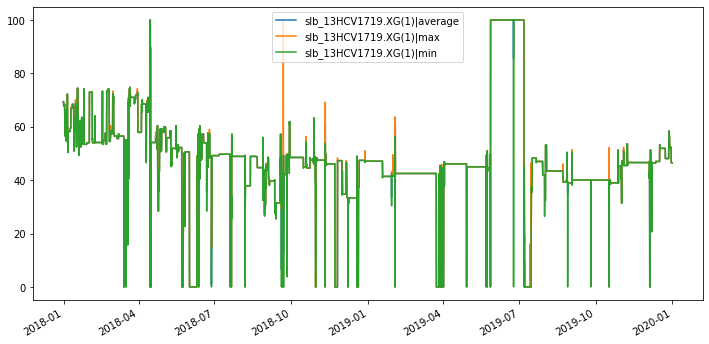

In [162]:
df.plot(figsize=(12,6))

It is also possible to search directly for time series insteady of going via the assets

In [61]:
from cognite.client.data_classes import TimeSeriesFilter

# We search for all time series with the UNIT_TYPE = PRESSURE in the metadata
my_ts_filter = TimeSeriesFilter(metadata = {'UNIT_TYPE':'PRESSURE'}) #,'descriptor':'W11'

res = client.time_series.search(description="W11",filter =my_ts_filter) 
res

,id,external_id,name,is_string,metadata,unit,asset_id,is_step,description,security_categories,data_set_id,created_time,last_updated_time
0,801203523520100,slb_13PST1721.X,slb_13PST1721.X,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,2452724833064541,False,"Downstream production choke Pressure sensor, s...",[],7818216168129302,1668331533762,1668334874496
1,8505391194049429,slb_13PT5310.Y,slb_13PT5310.Y,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,2158886742910667,False,"Wellhead Pressure sensor, slb W11",[],7818216168129302,1668331534669,1668334877190
2,2011027053666193,slb_13PT5322.Y,slb_13PT5322.Y,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,8545107235706786,False,"Downhole Pressure sensor, slb W11",[],7818216168129302,1668331533762,1668334877371
3,3453369986947129,slb_13PST1621.X,slb_13PST1621.X,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,2777639262895439,False,"Downstream production choke Pressure sensor, s...",[],7818216168129302,1668331535354,1668334874274
4,216346676107890,slb_13PST2021.X,slb_13PST2021.X,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,4232934491069416,False,"Downstream production choke Pressure sensor, s...",[],7818216168129302,1668331533762,1668334874714
5,3952643089807022,slb_13PST2321.X,slb_13PST2321.X,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,7654162890604259,False,"Downstream production choke Pressure sensor, s...",[],7818216168129302,1668331533030,1668334874952
6,5921952143665271,slb_13PST2421.X,slb_13PST2421.X,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,7640725538549458,False,"Downstream production choke Pressure sensor, s...",[],7818216168129302,1668331533030,1668334875367
7,4513943760218402,slb_13PT5260.Y,slb_13PT5260.Y,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,4324234267236905,False,"Wellhead Pressure sensor, slb W10",[],7818216168129302,1668331535974,1668334876687
8,690357810237475,slb_13PT5272.Y,slb_13PT5272.Y,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,5665983157893078,False,"Downhole Pressure sensor, slb W10",[],7818216168129302,1668331536179,1668334876973
9,2917911046493967,slb_13PT5460.Y,slb_13PT5460.Y,False,"{'unit_type': 'PRESSURE', 'linked_assets': 'sl...",bara,6995291527767301,False,"Wellhead Pressure sensor, slb W15",[],7818216168129302,1668331534038,1668334877586


# Sequences

retrieve the sequence

In [63]:
cv_curve = w11_prod_choke.sequences()[0]
cv_curve

,value
id,3383112559955700
name,slb_13HCV1719.CV.curve.multiphase
description,CV assuming multiphase flow for LER-WELL11
asset_id,7998780323041683
external_id,slb_13HCV1719.CV.curve.multiphase
columns,"[{'externalId': 'choke', 'description': 'Choke..."
created_time,1668347084050
last_updated_time,1668347084050
data_set_id,7818216168129302


retrieve the data points in the sequence

In [66]:
df_cv_curve = client.sequences.data.retrieve_dataframe(id=cv_curve.id, start=0, end=None)
df_cv_curve

,choke,cv
0,0.0,0.0
1,10.0,25.0
2,20.0,80.0
3,30.0,170.0
4,40.0,270.0
5,50.0,440.0
6,60.0,610.0
7,70.0,790.0
8,80.0,990.0
9,90.0,1150.0


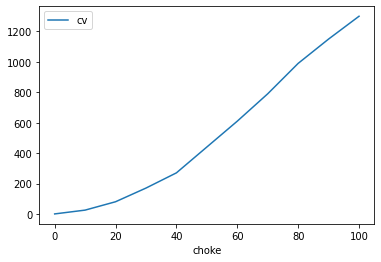

In [72]:
ax1 = df_cv_curve.plot.line(x='choke',y='cv')

Search for sequences without going through the asset

In [73]:
 # Fluid description for slb 1 well W11
 seq = client.sequences.search(description="Fluid W11",limit=5)
 seq

,id,name,description,asset_id,external_id,metadata,columns,created_time,last_updated_time,data_set_id
0,2567654242349767,slb1_W11_fluid_properties,Fluid description for Lervik 1 well W11,4961091162721077,slb1_W11_fluid_properties,{},"[{'externalId': 'TM', 'description': 'Temperat...",1668347080178,1668347080178,7818216168129302
1,4647778647573144,slb1_W06_fluid_properties,Fluid description for Lervik 1 well W06,6186033841805401,slb1_W06_fluid_properties,{},"[{'externalId': 'TM', 'description': 'Temperat...",1668347086883,1668347086883,7818216168129302
2,5862674973167824,slb1_W08_fluid_properties,Fluid description for Lervik 1 well W08,3717162782164552,slb1_W08_fluid_properties,{},"[{'externalId': 'TM', 'description': 'Temperat...",1668347068340,1668347068340,7818216168129302
3,8640878566095566,slb1_W10_fluid_properties,Fluid description for Lervik 1 well W10,3662708087613655,slb1_W10_fluid_properties,{},"[{'externalId': 'TM', 'description': 'Temperat...",1668347092792,1668347092792,7818216168129302
4,890807746171895,slb1_W15_fluid_properties,Fluid description for Lervik 1 well W15,5078069282499882,slb1_W15_fluid_properties,{},"[{'externalId': 'TM', 'description': 'Temperat...",1668347074172,1668347074172,7818216168129302


In [74]:
# Pull the data in the sequence
fluid_sequence = client.sequences.data.retrieve_dataframe(id=seq[0].id,start=0,end=None)
fluid_sequence

,TM,PT,RS,RSW,ROG,ROHL,ROWT,VISG,VISHL,VISWT,...,TCWT,CPG,CPHL,CPWT,HG,HHL,HWT,SEG,SEHL,SEWT
0,-10.150000,100000.0,0.122670,0.002093,1.140193,880.392594,1004.046200,0.000009,0.010859,0.002292,...,0.550919,1807.73962,1599.90547,4519.82012,-67100.3390,-374983.83,-2585715.0,122.302057,-779.36197,-7113.8533
1,-9.038889,100000.0,0.123395,0.002277,1.138932,880.189793,1003.867890,0.000009,0.010449,0.002219,...,0.552797,1809.42904,1605.72793,4530.50498,-65036.7360,-373155.42,-2580687.1,131.245871,-772.30244,-7094.7758
2,-7.927778,100000.0,0.124123,0.002475,1.137682,879.983362,1003.686110,0.000009,0.010059,0.002148,...,0.554681,1811.15649,1611.55123,4541.17692,-62973.3920,-371320.68,-2575647.2,140.172830,-765.25185,-7075.7337
3,-6.816667,100000.0,0.124854,0.002687,1.136443,879.773434,1003.500860,0.000009,0.009688,0.002080,...,0.556570,1812.91980,1617.37501,4551.83578,-60910.1910,-369479.55,-2570595.6,149.084921,-758.20984,-7056.7265
4,-5.705556,100000.0,0.125587,0.002916,1.135220,879.560146,1003.312110,0.000009,0.009336,0.002015,...,0.558466,1814.71681,1623.19888,4562.48141,-58847.0300,-367631.99,-2565532.1,157.984034,-751.17604,-7037.7542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,95.405556,20000000.0,0.000000,0.005798,178.059970,718.875935,973.217357,0.000023,0.000506,0.000302,...,0.683325,3129.20889,2219.02217,3980.41526,-21095.8780,-152007.00,-2142093.1,-1506.898100,-309.67230,-5753.7329
9996,96.516667,20000000.0,0.000000,0.005994,177.809739,717.962314,972.633145,0.000023,0.000501,0.000298,...,0.683955,3125.27049,2223.70885,3987.13997,-18162.4580,-149540.30,-2137663.0,-1492.074400,-302.99095,-5741.7328
9997,97.627778,20000000.0,0.000000,0.006195,177.551927,717.045212,972.042921,0.000023,0.000497,0.000294,...,0.684570,3158.87274,2250.46799,3993.97164,-15192.5860,-147049.34,-2133225.4,-1477.304200,-296.26473,-5729.7481
9998,98.738889,20000000.0,0.000000,0.006401,177.302692,716.124644,971.446649,0.000023,0.000492,0.000291,...,0.685171,3161.11858,2258.82814,4000.90646,-12217.6060,-144545.67,-2128779.9,-1462.527600,-289.52494,-5717.7782


Text(0.5, 0.5, 'Pressure [bar]')

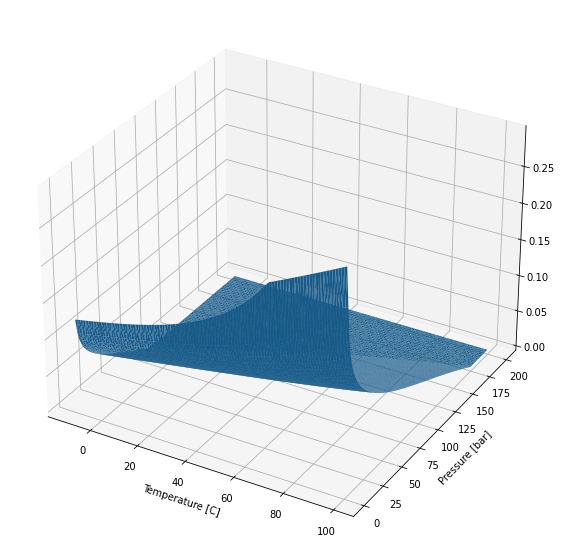

In [75]:
# Plot the gas-oil ratio
import pylab as plt
ax = plt.figure(figsize=(12,10)).add_subplot(projection='3d')
ax.plot_trisurf(fluid_sequence.TM.values, fluid_sequence.PT.values*1e-5, fluid_sequence.RS.values, linewidth=0.2, antialiased=True)
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Pressure [bar]')

# Events

fetch all events assosiated to this asset

In [76]:
w11_events = w11_prod_choke.events()
w11_events

,external_id,data_set_id,start_time,end_time,type,subtype,description,metadata,asset_ids,source,id,last_updated_time,created_time
0,slb.CWO-1006276,7818216168129302,1522713600000,1524614400000,Workorder,Mechanical,External leakage in actuator for production ch...,{'WORKORDER_TYPEANDMETHOD': 'MAI - 30 CWO Korr...,"[4961091162721077, 7998780323041683]",Workmate.VM_WORKORDER,61534452674705,1668346235439,1668346235439
1,slb.31077_13HCV1719,7818216168129302,1523664000000,1523750400000,EquipMaint,C22,Replacement: Replace unit with similar type. C...,"{'EQUIPHIST_FAILURECAUSECODE': '66', 'EQUIPHIS...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,344276700728444,1668346235625,1668346235625
2,slb.131486_13HCV1719,7818216168129302,1524096000000,1524182400000,EquipMaint,C22,Inspection: Investigation of cause of error or...,"{'EQUIPHIST_FAILURECAUSECODE': '73', 'EQUIPHIS...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,280405006272794,1668346235736,1668346235736
3,slb.36869_13HCV1719,7818216168129302,1537747200000,1537833600000,EquipMaint,C22,Replacement: Replacement of unit with similar ...,"{'TAG_TISLOCATIONNAME': 'slb 1', 'EQUIPHIST_FA...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,5442996316198057,1668346235911,1668346235911


In [77]:
# Add a filter to the retrievel of the events
res = w11_prod_choke.events(type= 'EquipMaint') 
res

,external_id,data_set_id,start_time,end_time,type,subtype,description,metadata,asset_ids,source,id,last_updated_time,created_time
0,slb.31077_13HCV1719,7818216168129302,1523664000000,1523750400000,EquipMaint,C22,Replacement: Replace unit with similar type. C...,"{'EQUIPHIST_FAILURECAUSECODE': '66', 'EQUIPHIS...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,344276700728444,1668346235625,1668346235625
1,slb.131486_13HCV1719,7818216168129302,1524096000000,1524182400000,EquipMaint,C22,Inspection: Investigation of cause of error or...,"{'EQUIPHIST_FAILURECAUSECODE': '73', 'EQUIPHIS...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,280405006272794,1668346235736,1668346235736
2,slb.36869_13HCV1719,7818216168129302,1537747200000,1537833600000,EquipMaint,C22,Replacement: Replacement of unit with similar ...,"{'TAG_TISLOCATIONNAME': 'slb 1', 'EQUIPHIST_FA...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,5442996316198057,1668346235911,1668346235911


In [78]:
# Inspect an event
w11_events[0]

,value
external_id,slb.CWO-1006276
data_set_id,7818216168129302
start_time,1522713600000
end_time,1524614400000
type,Workorder
subtype,Mechanical
description,External leakage in actuator for production ch...
asset_ids,"[4961091162721077, 7998780323041683]"
source,Workmate.VM_WORKORDER
id,61534452674705


Search for the events, without going via the asset

In [79]:
from cognite.client.data_classes import EventFilter
my_event_filter = EventFilter(type='EquipMaint') 

res = client.events.search(filter =my_event_filter) 
res

,external_id,data_set_id,start_time,end_time,type,subtype,description,metadata,asset_ids,source,id,last_updated_time,created_time
0,slb.31077_13HCV1719,7818216168129302,1523664000000,1523750400000,EquipMaint,C22,Replacement: Replace unit with similar type. C...,"{'EQUIPHIST_FAILURECAUSECODE': '66', 'EQUIPHIS...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,344276700728444,1668346235625,1668346235625
1,slb.36869_13HCV1719,7818216168129302,1537747200000,1537833600000,EquipMaint,C22,Replacement: Replacement of unit with similar ...,"{'TAG_TISLOCATIONNAME': 'slb 1', 'EQUIPHIST_FA...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,5442996316198057,1668346235911,1668346235911
2,slb.131486_13HCV1719,7818216168129302,1524096000000,1524182400000,EquipMaint,C22,Inspection: Investigation of cause of error or...,"{'EQUIPHIST_FAILURECAUSECODE': '73', 'EQUIPHIS...","[4961091162721077, 7998780323041683]",WorkMate.EquipMaint,280405006272794,1668346235736,1668346235736


# Syntetic time series

In [177]:
from cognite.client.data_classes import TimeSeriesFilter
my_ts_filter = TimeSeriesFilter(metadata = {'UNIT_TYPE':'FLOW','PHASE':'OIL'})#,'descriptor':'Oil rate'}) #,'descriptor':'W11'

ts_list = client.time_series.search(name = '.OilVolStdStg1',filter =my_ts_filter) 
ts_list

,id,external_id,name,is_string,metadata,unit,asset_id,is_step,description,security_categories,data_set_id,created_time,last_updated_time
0,577484425574011,slb_W06.OilVolStdStg1,slb_W06.OilVolStdStg1,False,"{'UNIT_TYPE': 'FLOW', 'unit': 'Sm3/h', 'PHASE'...",Sm3/h,8205366419942597,False,"Oil volume rate at std, VFM, slb W06",[],7818216168129302,1668331535974,1668357469003
1,7415921047144005,slb_W08.OilVolStdStg1,slb_W08.OilVolStdStg1,False,"{'UNIT_TYPE': 'FLOW', 'unit': 'Sm3/h', 'PHASE'...",Sm3/h,1644085439224338,False,"Oil volume rate at std, VFM, slb W08",[],7818216168129302,1668331536179,1668357469593
2,787050526982995,slb_W10.OilVolStdStg1,slb_W10.OilVolStdStg1,False,"{'UNIT_TYPE': 'FLOW', 'unit': 'Sm3/h', 'PHASE'...",Sm3/h,6683824235173055,False,"Oil volume rate at std, VFM, slb W10",[],7818216168129302,1668331536179,1668357470175
3,8466540420849945,slb_W11.OilVolStdStg1,slb_W11.OilVolStdStg1,False,"{'UNIT_TYPE': 'FLOW', 'unit': 'Sm3/h', 'PHASE'...",Sm3/h,8017118909032715,False,"Oil volume rate at std, VFM, slb W11",[],7818216168129302,1668331535974,1668357470857
4,2285801203608402,slb_W15.OilVolStdStg1,slb_W15.OilVolStdStg1,False,"{'UNIT_TYPE': 'FLOW', 'unit': 'Sm3/h', 'PHASE'...",Sm3/h,4119278987432085,False,"Oil volume rate at std, VFM, slb W15",[],7818216168129302,1668331533030,1668357471386
5,80518728409869,slb_W18.OilVolStdStg1,slb_W18.OilVolStdStg1,False,"{'UNIT_TYPE': 'FLOW', 'unit': 'Sm3/h', 'PHASE'...",Sm3/h,4294444642725406,False,"Oil volume rate at std, VFM, slb W18",[],7818216168129302,1668331536674,1668357471935
6,1661545060503358,slb_W19.OilVolStdStg1,slb_W19.OilVolStdStg1,False,"{'UNIT_TYPE': 'FLOW', 'unit': 'Sm3/h', 'PHASE'...",Sm3/h,529566685067091,False,"Oil volume rate at std, VFM, slb W19",[],7818216168129302,1668331534669,1668357472405


In [198]:
from datetime import datetime
start_time = datetime(2018,1,1) # "2w-ago"
end_time = datetime(2020,1,1)   # "now"
vars = {'W%d'%(i+1):sensor.external_id for i,sensor in enumerate(ts_list)}
expressions = '+'.join(['W%d'%(i+1) for i,sensor in enumerate(ts_list) ])
expressions = 'W1+W3+W5+W6+W7' # While we are waiting for backfilling
dps = client.datapoints.synthetic.query(expressions=expressions, 
                                        start=start_time, 
                                        end=end_time, 
                                        variables=vars,
                                        granularity = '1h', 
                                        aggregate='interpolation')

C:\Users\GunnarStaff\AppData\Local\Programs\Python\Python38\lib\site-packages\cognite\client\utils\_time.py:16: FutureWarning: Interpreting given naive datetime as UTC instead of local time (against Python default behaviour). This will change in the next major release (4.0.0). Please use (timezone) aware datetimes or convert it yourself to integer (number of milliseconds since epoch, leap seconds excluded).
  warnings.warn(


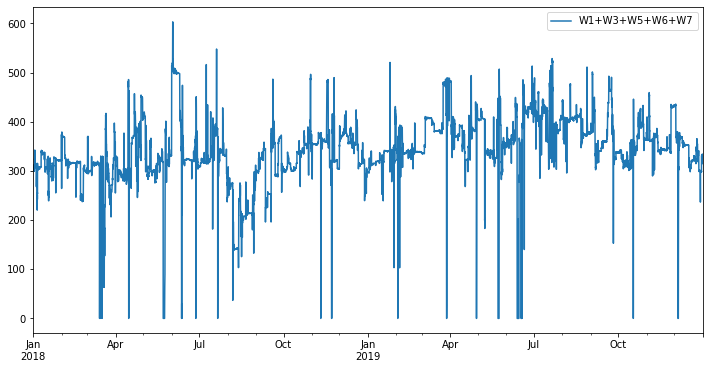

In [197]:
dps.plot(figsize=(12,6))

# Templates

List existing template groups

In [88]:
client.templates.groups.list()

,external_id,description,owners,created_time,last_updated_time
0,Well_demo,Template group for well template,[],1668350880849,1668351290023


List all instances of a spesific template

In [89]:
template_group_name = 'Well_demo'
instances = client.templates.instances.list(template_group_name, 1, template_names = ["slbwells"])#limit=5)
instances

,external_id,template_name,field_resolvers,created_time,last_updated_time
0,slb-WELL08,slbwells,"{'Wvalve': {'type': 'constant', 'value': 'slb_...",1668351372570,1668354481904
1,slb-WELL10,slbwells,"{'Wvalve': {'type': 'constant', 'value': 'slb_...",1668351386226,1668354481904
2,slb-WELL15,slbwells,"{'Wvalve': {'type': 'constant', 'value': 'slb_...",1668351433757,1668354481904
3,slb-WELL06,slbwells,"{'Wvalve': {'type': 'constant', 'value': 'slb_...",1668351361679,1668354481904
4,slb-WELL18,slbwells,"{'Wvalve': {'type': 'constant', 'value': 'slb_...",1668351444273,1668354481904
5,slb-WELL19,slbwells,"{'Wvalve': {'type': 'constant', 'value': 'slb_...",1668351454883,1668354481904
6,slb-WELL11,slbwells,"{'Wvalve': {'type': 'constant', 'value': 'slb_...",1668351397851,1668354481904


What type of info do I have available?

In [90]:
print([item for item in instances[0].field_resolvers])

['Wvalve', 'BHT', 'QO_VFM', 'WHT', 'QG_VFM', 'Qgl', 'choke', 'ProdP', 'WHP', 'name', 'QW_VFM', 'BHP', 'MESV']


We can query using graphQl

In [205]:
query = '''
   {
       slbwellsQuery{
       items{
          name,
          BHP {
            aggregatedDatapoints(
              start:  1514789980000,
              end:    1514836080000,
              granularity: "1h",
              limit: 10000,
            ) {
                average {
                  timestamp,
                  value
                }
                continuousVariance  {
                  timestamp,
                  value
                }
            }
          }
       }
    }
}
   '''
result = client.templates.graphql_query("Well_demo", 1, query)

In [206]:
result.data

{'slbwellsQuery': {'items': [{'name': 'slb-WELL08',
    'BHP': {'aggregatedDatapoints': {'average': [],
      'continuousVariance': []}}},
   {'name': 'slb-WELL10',
    'BHP': {'aggregatedDatapoints': {'average': [{'timestamp': 1514786400000,
        'value': 147.8029491821925},
       {'timestamp': 1514790000000, 'value': 147.80919639587404},
       {'timestamp': 1514793600000, 'value': 147.8105370322863},
       {'timestamp': 1514797200000, 'value': 147.80802565336228},
       {'timestamp': 1514800800000, 'value': 147.80480339447658},
       {'timestamp': 1514804400000, 'value': 147.8024347949028},
       {'timestamp': 1514808000000, 'value': 147.79728253761925},
       {'timestamp': 1514811600000, 'value': 147.78651543696722},
       {'timestamp': 1514815200000, 'value': 147.77590964317324},
       {'timestamp': 1514818800000, 'value': 147.76496081113817},
       {'timestamp': 1514822400000, 'value': 147.75749747117362},
       {'timestamp': 1514826000000, 'value': 147.7511654265721

Collecting time series data directly using the api calls

In [155]:
ts_tags = [instance.field_resolvers['BHP'].value for instance in instances]
from datetime import datetime
start_time = datetime(2018,1,1)
end_time = datetime(2020,1,1)
df_bhp = client.datapoints.retrieve_dataframe( external_id = ts_tags,
                                              granularity='1h',
                                              aggregates=['average'],
                                              start=start_time,
                                              end=end_time ,include_aggregate_name=False)

C:\Users\GunnarStaff\AppData\Local\Programs\Python\Python38\lib\site-packages\cognite\client\utils\_time.py:16: FutureWarning: Interpreting given naive datetime as UTC instead of local time (against Python default behaviour). This will change in the next major release (4.0.0). Please use (timezone) aware datetimes or convert it yourself to integer (number of milliseconds since epoch, leap seconds excluded).
  warnings.warn(


<AxesSubplot:>

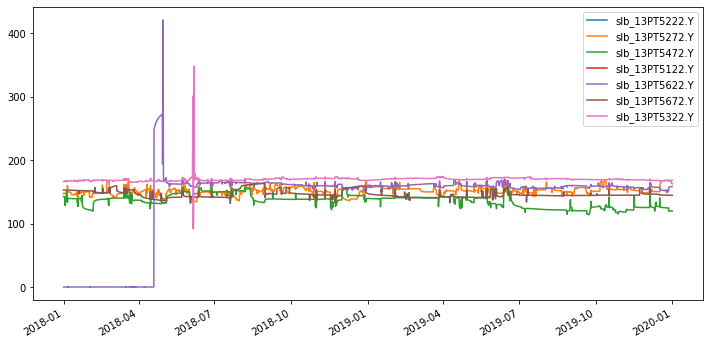

In [156]:
df_bhp.plot(figsize=(12,6))

# Functions

List existing functions

In [130]:
client.functions.list()

,id,name,external_id,description,status,file_id,function_path,created_time,secrets,cpu,memory,runtime,metadata,owner
0,131181023750864,func_oid_sync_ler2-23_v6_oidc,func_oid_sync_ler2-23_v6_oidc,This function retrieves datapoints (7 days ago...,Ready,6630801627178613,handler.py,1667075855688,{'secret': '***'},1.0,1.5,py38,{},NaN
1,3230545571730263,gst_demo,gst_demo,Functions demo,Deploying,1589564827813427,handler.py,1668355586156,NaN,1.0,1.5,py38,{},Gunnar Staff


create the function

In [146]:
def handle(client, data):
    # Some error handling
    if not type(data) is type(dict()):
        data={}
    if not 'external_id' in data:
        data['external_id']='slb_W10.OilVolStdStg1'
        
    ts=client.time_series.retrieve(external_id=data['external_id'])
    print(ts.latest())
    return ts.latest()

Testing the function

In [154]:
handle(client,data = {'external_id':'slb_W18.OilVolStdStg1'})

{
    "timestamp": "2022-11-13 12:32:30.782000",
    "value": 72.2677993774414
}


,value
2022-11-13 12:32:30.782,72.267799


In [147]:
# set up a new function. Takes several minutes to deploy
try:
    client.functions.delete(external_id="gst_demo")
except:
    pass
function = client.functions.create(name = "gst_demo", external_id="gst_demo", owner = "Gunnar Staff", description = "Functions demo", function_handle=handle)

In [150]:
function = client.functions.retrieve(external_id="gst_demo")
function

,value
id,3324138736705198
name,gst_demo
external_id,gst_demo
description,Functions demo
owner,Gunnar Staff
status,Ready
file_id,1589564827813427
function_path,handler.py
created_time,1668356042160
cpu,1.0


In [151]:
call = function.call( data = {'external_id':'slb_W18.OilVolStdStg1'})
call

,value
id,8159478522582745
start_time,1668356338087
end_time,1668356342855
status,Completed
function_id,3324138736705198


In [152]:
call.get_response()

{'_cognite_client': None,
 'average': None,
 'continuous_variance': None,
 'count': None,
 'discrete_variance': None,
 'interpolation': None,
 'max': None,
 'min': None,
 'step_interpolation': None,
 'sum': None,
 'timestamp': 1668342750782,
 'total_variation': None,
 'value': 72.2677993774414}

In [153]:
call.get_logs()

,timestamp,message
0,1668356342416,{
1,1668356342416,"""timestamp"": ""2022-11-13 12:32:30.782000"","
2,1668356342416,"""value"": 72.2677993774414"
3,1668356342416,}


# Login using Azure user
from cognite.client.credentials import Token
from msal import PublicClientApplication, SerializableTokenCache
import atexit

CACHE_FILENAME = "cache.bin"
SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000

def create_cache():
    cache = SerializableTokenCache()
    if os.path.exists(CACHE_FILENAME):
        cache.deserialize(open(CACHE_FILENAME, "r").read())
    atexit.register(lambda:
        open(CACHE_FILENAME, "w").write(cache.serialize()) if cache.has_state_changed else None
    )
    return cache


def authenticate_azure(app):
    # Firstly, check the cache to see if this end user has signed in before
    accounts = app.get_accounts()
    if accounts:
        creds = app.acquire_token_silent(SCOPES, account=accounts[0])
    else:
        # interactive login - make sure you have http://localhost:port in Redirect URI in App Registration as type "Mobile and desktop applications"
        creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT,)

    return creds

app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI, token_cache=create_cache())

def token_provider():
    return authenticate_azure(app)["access_token"]

cnf = ClientConfig(client_name="cognite", 
                   base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
                   project=COGNITE_PROJECT, credentials=Token(token_provider))
client = CogniteClient(cnf)